In [79]:
import openseespy.opensees as ops
import numpy as np
import matplotlib.pyplot as plt
import opsvis as opsv

In [80]:
ops.wipe()
ops.model('basic','-ndm',2,'-ndf',3)

In [81]:
#Materiales
fpc = -41000
epsc0 = -0.003
fpcu = 0.20*fpc
epsU = -0.006
lambdaC = 0.5
ft = 0.65*28*0.5*1000
Ets = (2*fpc/epsc0)
ops.uniaxialMaterial('Concrete02',1,fpc,epsc0,fpcu,epsU,lambdaC,ft,Ets)

Fy = 420000
E0 = 200000000
b = 0.007
ops.uniaxialMaterial('Steel02',2,Fy,E0,b)


In [82]:
#Crear Seccion
GJ = 1e14
ops.section('Fiber',1,'-GJ',GJ)

B = 0.55
H = 0.80
crdsI = [-H/2,-B/2]
crdsJ = [H/2,B/2]
ops.patch('rect',1,10,1,*crdsI,*crdsJ)

AN6 = 284e-6
ops.layer = ('straight',2,6,AN6,*[-H/2+0.05,-B/2+0.05],*[-H/2+0.05,B/2-0.05])
AN7 = 387e-6
ops.layer = ('straight',2,6,AN7,*[H/2-0.05,-B/2+0.05],*[H/2-0.05,B/2-0.05])

In [83]:
#Carga Axial de la Seccion
P = 0.0

#Nodos
ops.node(1,0.0,0.0)
ops.node(2,0.0,0.0)
ops.fix(1,1,1,1)
ops.fix(2,0,1,0)

#Elementos de longitud cero
ops.element('zeroLengthSection',1,1,2,1)

#Patron de carga axial
ops.timeSeries('Linear',1)
ops.pattern('Plain',1,1)
ops.load(2,P,0.0,0.0)

#Analisis
ops.constraints('Plain')
ops.numberer('Plain')
ops.system('BandGeneral')
ops.test('EnergyIncr',1.0e-6,30)
ops.algorithm('Newton')
NSteps = 10
ops.integrator('LoadControl',1/NSteps)
ops.analysis('Static')
ops.analyze(NSteps)
ops.wipeAnalysis()


In [84]:
ops.loadConst('-time',0.0)

#Definir el patron de carga
ops.timeSeries('Linear',2)
ops.pattern('Plain',2,2)
ops.load(2,0.0,0.0,1.0)

#Analisis
ops.constraints('Plain')
ops.numberer('Plain')
ops.system('BandGeneral')
ops.test('EnergyIncr',1.0e-6,100)
ops.algorithm('Newton')
maxK = 0.0021/(0.7*H)*20
numIncr = 1000
ops.integrator('DisplacementControl',2,3,maxK/numIncr)
ops.analysis('Static')

ops.recorder('Node','-file','moment_strain_curvatures.out','-time','node',2,'-dof',1,3,'disp')

while ops.nodeDisp(2,3) <= maxK:
    ok = ops.analyze(1)
    if  ok != 0:
        print('El analisis Momento Curvatura Fallo: ',ops.nodeDisp(2,3))
        break

ops.wipeAnalysis()
ops.remove('recorders')


El analisis Momento Curvatura Fallo:  0.008475000000000024


WARNING DisplacementControl::update() dUahat is zero -- zero reference displacement at control node DOF
WARNING NewtonRaphson::solveCurrentStep() -the Integrator failed in update()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 32.21
OpenSees > analyze failed, returned: -3 error flag


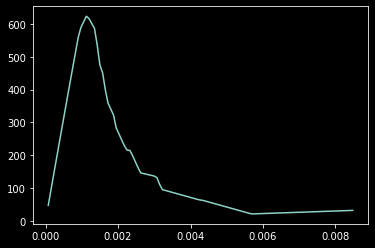

In [85]:
Mek = np.loadtxt('moment_strain_curvatures.out')
plt.figure()
plt.plot(Mek[:,4],Mek[:,0])
plt.show()